In [50]:
using ModelingToolkit, DifferentialEquations, Plots, LinearAlgebra
using ModelingToolkit: t_nounits as t, D_nounits as D

#An attempt to use vecorized representation for the standard Lotka-Volterra model.

#First build the symbolic model

#Set the number of patches
Np=2
#Set the number of corridors
Nc=1

#patches
@variables p(t)[1:Np]
#corridors
@variables c(t)[1:Np,1:Np,1:Nc] #note, this is only for 1 corridor and will have to be modifed.

#=
Note, think about generalizing c(t) for multiple corridors... i.e. c(t)[1:Nc,1:Np,1:Np]
I have not tested this, but this shold make a Nc x Np x Np array.
=#


@parameters α[1:Nc] 
@parameters β[1:Nc] 
@parameters d[1:Np, 1:Np]

#=

Note, think about generalizing the above for directions, i.e. add more dimensions
to the array where, again, there will be lots of zeros...

=#

#=
define a general flux at a node connection (between a patch and a corridor),
that is, the flux entering and exiting corridors. All fluxes are defined for 
corridors, not patches.  Net Fluxes for patches are then summed over all corridors
connected to a patch, i.e. sum in - sum out. This should allow us to write the patch 
fluxes and corridor fluxes in a very systematic way, and we should end up with 
something like

D.(p) = NPF
D.(c) = NCF

where NPF and NCF are the net patch and corridor fluxes appropriately defined.

=#

EnFlx(p,c,d,α,β) = d * exp(-α * β * c) * p
ExFlx(c,β) = exp(-β*c)*c

#=
so, for example, the fluxes from p1 and p2 into corridor 1 would be

EnFlx(p[1],c[1,2],d[1],α[1],β[1])
EnFlx(p[2],c[2,1],d₂,α₂,β₂)

etcetera

=#

#define the corridor flux matrix

eqs = [
    D.(p[1]) ~ ExFlx(c[2,1,1],β[1]) - EnFlx(p[1],c[1,2,1],d[1,2],α[1],β[1]),
    D.(p[2]) ~ ExFlx(c[1,2,1],β[1]) - EnFlx(p[2],c[2,1,1],d[2,1],α[1],β[1]),
    D.(c[1,2,1]) ~ - ExFlx(c[1,2,1],β[1]) + EnFlx(p[1],c[1,2,1],d[1,2],α[1],β[1]),
    D.(c[2,1,1]) ~ - ExFlx(c[2,1,1],β[1]) + EnFlx(p[2],c[2,1,1],d[2,1],α[1],β[1]) 
]

#define equations

#eqs = [
 #   D.(p) ~ collect(c*p)
  #      ]

#build model symbolically
@mtkbuild model = ODESystem(eqs, t)


Model model with 4 equations
Unknowns (4):
  (p(t))[1]
  (p(t))[2]
  (c(t))[1, 2, 1]
  (c(t))[2, 1, 1]
Parameters (4):
  d[2, 1]
  d[1, 2]
  α
  β

OK, so this works beautifully, and if you stare at it for a while you should be able to generalize. But first, create the numerical problem and solve it... Notice that it didn't complain about us not using c[1,1] and c[2,2]. But when we generalize, these will all be there, but set to zero.  Maybe the best way to proceed is to just have this file with subseqent cells as incremental generalizations.

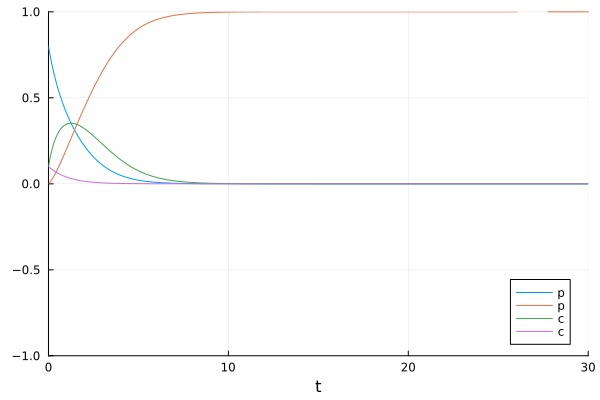

In [51]:
# build numerical problem to solve
my_α = [1]
my_β = [1]
my_d = [0 1; 0 0]

prob = ODEProblem(model, [p[1]=>0.8,p[2]=>0.0,c[1,2,1]=>0.1,c[2,1,1]=>0.1], (0.0, 30), [α => my_α, β=>my_β, d=>my_d])

#numerically solve the problem and plot it

sol = solve(prob,Tsit5())
plot(sol, idxs = (p[1]), ylim=(-1,1))
plot!(sol, idxs = (p[2]), xlim=(0,30))
plot!(sol, idxs = (c[1,2,1]))
plot!(sol, idxs = (c[2,1,1]))

2×2×1 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.1
 0.1  0.0

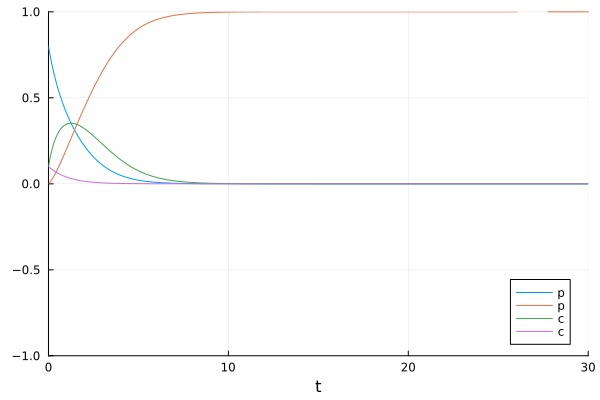

In [52]:
# build numerical problem to solve
my_α = [1]
my_β = [1]
my_d = [0 1; 0 0]
cm = zeros(2,2,1)
cm[1,2,1] = 0.1
cm[2,1,1] = 0.1
display(cm)

prob = ODEProblem(model, [p[1]=>0.8,p[2]=>0.0,c=>cm], (0.0, 30), [α => my_α, β=>my_β, d=>my_d])

#numerically solve the problem and plot it

sol = solve(prob,Tsit5())
plot(sol, idxs = (p[1]), ylim=(-1,1))
plot!(sol, idxs = (p[2]), xlim=(0,30))
plot!(sol, idxs = (c[1,2,1]))
plot!(sol, idxs = (c[2,1,1]))

## More generally

In [112]:
using ModelingToolkit, DifferentialEquations, Plots, LinearAlgebra
using ModelingToolkit: t_nounits as t, D_nounits as D

#An attempt to use vecorized representation for the standard Lotka-Volterra model.

#First build the symbolic model

#Set the number of patches
Np=2
#Set the number of corridors
Nc=2

#patches
@variables p(t)[1:Np]
#corridors
@variables c(t)[1:Np,1:Np,1:Nc] # notice that we must specify the number of corridors (layers) in the *last* index

@parameters α[1:Nc]
@parameters β[1:Nc]
@parameters d[1:Np]

#define the corridor flux matrices

EnFlx(p,c,d,α,β) = exp.(-α .* β .* c) .* p .* d
ExFlx(c,β) = exp.(-β.*c).*c

#define equations

eqs = [
    D.(p) ~ [sum(ExFlx(c,β[1])[:,i,:]) for i in 1:Np] .- [sum(EnFlx(p,c,d,α[1],β[1])[i,:,:]) for i in 1:Np],
    D.(c) ~ collect(-ExFlx(c,β[1]) + EnFlx(p,c,d,α[1],β[1])),
]
#=
  Notice we only used "collect()" in the equation for D.(c). 
  For D.(p), we summed over the columns of the EnFlx matrix and over the columns of the ExFlx matrix, 
  then took their difference. If you don't do this (summing), you will get an error because you will be 
  attempting to save an object of shape (2,2,1) into an object of shape (2,).
=#

#build model symbolically
@mtkbuild model = ODESystem(eqs, t)


Model model with 10 equations
Unknowns (10):
  (p(t))[1]
  (p(t))[2]
  (c(t))[1, 1, 1]
  (c(t))[2, 1, 1]
  (c(t))[1, 2, 1]
  (c(t))[2, 2, 1]
⋮
Parameters (3):
  β[1]
  α[1]
  d

Numerical solve

In [79]:
my_α = [1]
my_β = [1]
my_d = [0 1; 0 0]
cm = zeros(2,2,1)
cm[1,2,1] = 0.15
cm[2,1,1] = 0.05
pm = [0.8; 0.0]

EnFlx(p,c,d,α,β) = d .* exp.(-α .* β .* c) .* p
ExFlx(c,β) = exp.(-β.*c).*c

en_flux = EnFlx(pm, cm, my_d, my_α, my_β)
exit_flux = ExFlx(cm, my_β)

display(en_flux)
display(exit_flux)

pm_minus = [sum(en_flux[i, :, :]) for i in 1:Np] # row i, all columns, first "layer"
pm_plus = [sum(exit_flux[:, i, :]) for i in 1:Np] # all rows, column i, first "layer"

display(pm_minus)
display(pm_plus)

new_pm = pm_plus .- pm_minus
display(new_pm)

2×2×1 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.688566
 0.0  0.0

2×2×1 Array{Float64, 3}:
[:, :, 1] =
 0.0        0.129106
 0.0475615  0.0

2-element Vector{Float64}:
 0.6885663811400463
 0.0

2-element Vector{Float64}:
 0.047561471225035706
 0.12910619646375868

2-element Vector{Float64}:
 -0.6410049099150106
  0.12910619646375868

## 2 corridors, 2 patches

In [92]:
using ModelingToolkit, DifferentialEquations, Plots, LinearAlgebra
using ModelingToolkit: t_nounits as t, D_nounits as D

#An attempt to use vecorized representation for the standard Lotka-Volterra model.

#First build the symbolic model

#Set the number of patches
Np=2
#Set the number of corridors
Nc=2

#patches
@variables p(t)[1:Np]
#corridors
@variables c(t)[1:Np,1:Np,1:Nc] # notice that we must specify the number of corridors (layers) in the *last* index

@parameters α[1:Nc]
@parameters β[1:Nc]
@parameters d[1:Np, 1:Np]

#define the corridor flux matrices

EnFlx(p,c,d,α,β) = exp.(-α .* β .* c) .* p .* d
ExFlx(c,β) = exp.(-β.*c).*c

#define equations

eqs = [
    D.(p) ~ [sum(ExFlx(c,β[1])[:,i,:]) for i in 1:Np] .- [sum(EnFlx(p,c,d,α[1],β[1])[i,:,:]) for i in 1:Np],
    D.(c) ~ collect(-ExFlx(c,β[1]) + EnFlx(p,c,d,α[1],β[1])),
]
#=
  Notice we only used "collect()" in the equation for D.(c). 
  For D.(p), we summed over the columns of the EnFlx matrix and over the columns of the ExFlx matrix, 
  then took their difference. If you don't do this (summing), you will get an error because you will be 
  attempting to save an object of shape (2,2,1) into an object of shape (2,).
=#

#build model symbolically
@mtkbuild model = ODESystem(eqs, t)


Model model with 10 equations
Unknowns (10):
  (p(t))[1]
  (p(t))[2]
  (c(t))[1, 1, 1]
  (c(t))[2, 1, 1]
  (c(t))[1, 2, 1]
  (c(t))[2, 2, 1]
⋮
Parameters (3):
  β[1]
  α[1]
  d

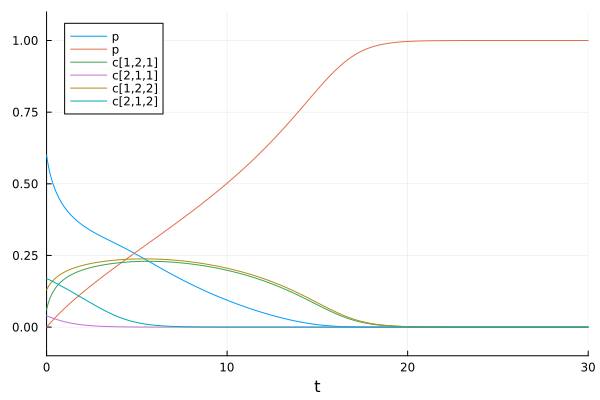

In [107]:
my_α = [1; 1]
my_β = [10; 1]
my_d = [0 1; 0 0]
cm = zeros(2,2,2)
cm[1,2,1] = 0.06
cm[2,1,1] = 0.04
cm[1,2,2] = 0.13
cm[2,1,2] = 0.17
pm = [0.6; 0.0]

prob = ODEProblem(model, [p=>pm,c=>cm], (0.0, 30), [α => my_α, β=>my_β, d=>my_d])

#numerically solve the problem and plot it

sol = solve(prob,Tsit5())
plot(sol, idxs = (p[1]), ylim=(-0.1,1.1))
plot!(sol, idxs = (p[2]), xlim=(0,30))
plot!(sol, idxs = (c[1,2,1]), label="c[1,2,1]")
plot!(sol, idxs = (c[2,1,1]), label="c[2,1,1]")
plot!(sol, idxs = (c[1,2,2]), label="c[1,2,2]")
plot!(sol, idxs = (c[2,1,2]), label="c[2,1,2]")

## How do we know those equations are right?
Well, here are some diagrams to help us keep track of what each of those terms mean


<img src="https://github.com/acossairt/traffic_air_quality_modeling/blob/main/images/julia_notation_diagram_1.png" alt="Diagram for indexing notation" title="Diagram for indexing notation" />

<img src="https://github.com/acossairt/traffic_air_quality_modeling/blob/main/images/julia_notation_diagram_2.png" alt="Diagram for indexing notation" title="Diagram for indexing notation" />

![alt text](https://github.com/acossairt/traffic_air_quality_modeling/blob/main/images/julia_notation_diagram_1.png?raw=true)

![alt text](https://github.com/acossairt/traffic_air_quality_modeling/blob/main/images/julia_notation_diagram_2.png?raw=true)